In [2]:
import json
import numpy as np
from qiskit.circuit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit_aer import Aer
from qiskit import transpile
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp,Operator, state_fidelity, Statevector, partial_trace, entropy
import random
from scipy.optimize import minimize

# 2 qubit entanglement detection
In this notebook I will se how we can detect 2 qubit entanglement using VQAs or similar procedures.

First we open the 4000 random unitaries form the json

In [3]:
with open(r"C:\Users\aquim\OneDrive\Desktop\Master\TFM\random_unitaries_2q.json", "r") as f:
    loaded_data = json.load(f)

# Convert back to NumPy arrays
loaded_matrices = [
    np.array(data["real"]) + 1j * np.array(data["imag"])
    for data in loaded_data
]
print(len(loaded_matrices))

4000


We have now stored the 4000 complex matrices in the loaded_matrices vector.
With this 4000 unitaries we will create a set of 2000 training states and 2000 test states.


In [7]:
training = loaded_matrices[0:2000]
test = loaded_matrices[2000:4000]

In [4]:
len(training)

2000

## Geometric measure of entanglement 

The first method we will review is the entanglement detection through the geometric measure (GME). This is a monotone which provides a quantification of how close this state is to the closest possible separable state. This closeness is calculated using the fideleity:
$$F(|\psi\rangle , |\phi\rangle) = |\langle \psi | \phi \rangle|^2 $$
We de define GME as:
$$E(|\psi \rangle) = 1 - \Lambda_{\psi}^2$$
Where the $\Lambda_{\psi}$ is defined as:
$$\Lambda_{\psi}^2 = max_{|\phi\rangle \in SEP} F(|\psi\rangle , |\phi\rangle) $$
If E is zero we have that the quantum state is separable, otherwise it is entangled.

By maximazing the fidelity, we try to obtain the closest separable state to the one we want to classify. It is worth noting that this procedure is possible because the set of separable states is a convex set.

In [14]:
backend = Aer.get_backend('statevector_simulator')

For the cost function, we calculate the fidelity the two circuits by using the fidelity function provided by qiskit.

In [6]:
def cost_fun(params,ansatz1,ansatz2,backend):
    ansatz2 = ansatz2.assign_parameters(params)
    isa_ansatz = transpile(ansatz1,backend=backend)
    isa_ansatz2 = transpile(ansatz2,backend=backend)
    sv1 = Statevector(isa_ansatz)
    sv2 = Statevector(isa_ansatz2)
    fid = state_fidelity(sv1,sv2)
    return -fid

For the benchmarking of this method, I define 3 quantum variational circuits:
1. ansatz_sep: variational quantum circuit with 6 parameters. I selected this ansatz because the 3 possible rotations (rx,ry,rz) consider every single state in the Bloch Sphere for each qubit. There is no entangling gates, which makes this ansatz separable.
2. qc: the first named qc quantum circuit creates the entangled state using the unitaries from the random unitary training dataset.
3. qc: the second qc quantum circuit creates a separable state using the unitaries from the traininf dataset.

In [7]:
len(training)/8

250.0

In [ ]:
ansatz_sep = QuantumCircuit(2)
params = ParameterVector('θ',6)
ansatz_sep.ry(params[0],0)
ansatz_sep.rx(params[1],0)
ansatz_sep.ry(params[2],1)
ansatz_sep.rx(params[3],1)
ansatz_sep.rz(params[4],0)
ansatz_sep.rz(params[5],1)
real_label= []
q = 0
geom_entr = []
for i in range(0,int(len(training)/8),2):
    print(f'State {q}')
    q+=1
    x0 = np.random.rand(6) * 2 * np.pi
    rand_num = np.random.rand()
    # We select randomely if the generated state is entangled or not
    if rand_num <= 1/3:   
        # Entangled state generator
        real_label.append(1)
        x0 = np.random.rand(6) * 2 * np.pi
        qc =QuantumCircuit(2)
        qc.h(0)# We first create the  Bell state
        qc.cx(0,1)
        U_ = np.kron(training[i],training[i+1])# We do the tensor product and create the entangled state
        qc.unitary(Operator(U_), [0,1], label="U1⊗U2")
        qc.barrier()
    elif rand_num>1/3 and rand_num<=2/3:
        # Separated state
        real_label.append(0)
        x0 = np.random.rand(6) * 2 * np.pi
        qc =QuantumCircuit(2)
        U_ = np.kron(training[0],training[1])
        qc.unitary(Operator(U_), [0,1], label="U1⊗U2")
        qc.barrier()
    elif rand_num>2/3:
        # Non maximally entangled state
        real_label.append(1)
        r = np.random.rand(4) # We create a vector of 4 random amplitudes
        r_norm = r/np.linalg.norm(r) # We normalize the vector
        phi = np.random.rand(4) * 2 * np.pi # We create a random phase
        target_state = np.array([
            r_norm[0] * np.exp(1j * phi[0]),
            r_norm[1] * np.exp(1j * phi[1]),
            r_norm[2] * np.exp(1j * phi[2]),
            r_norm[3] * np.exp(1j * phi[3])
        ])
        target_state = Statevector(target_state)
        qc = QuantumCircuit(2)
        qc.initialize(target_state.data, [0, 1]) # We initialize the state
        qc.barrier()
    res = minimize(cost_fun,x0,args = (qc,ansatz_sep,backend),method='cobyla',tol=0.1)
    geom_entr.append(-res['fun'])
    

State 0
State 1
State 2
State 3
State 4
State 5
State 6
State 7
State 8
State 9
State 10
State 11
State 12
State 13
State 14
State 15
State 16
State 17
State 18
State 19
State 20
State 21
State 22
State 23
State 24
State 25
State 26
State 27
State 28
State 29
State 30
State 31
State 32
State 33
State 34
State 35
State 36
State 37
State 38
State 39
State 40
State 41
State 42
State 43
State 44
State 45
State 46
State 47
State 48
State 49
State 50
State 51
State 52
State 53
State 54
State 55
State 56
State 57
State 58
State 59
State 60
State 61
State 62
State 63
State 64
State 65
State 66
State 67
State 68
State 69
State 70
State 71
State 72
State 73
State 74
State 75
State 76
State 77
State 78
State 79
State 80
State 81
State 82
State 83
State 84
State 85
State 86
State 87
State 88
State 89
State 90
State 91
State 92
State 93
State 94
State 95
State 96
State 97
State 98
State 99
State 100
State 101
State 102
State 103
State 104
State 105
State 106
State 107
State 108
State 109
State 110


In [34]:
E = [(1 - p**2) for p in geom_entr]
for i in range(len(E)):
    # I set a bound at 0.1 for classification of separable and entangled
    if E[i] < 0.01:
        E[i]=0
    elif E[i]>=0.01:
        E[i]=1
q= 0
for z in range(len(real_label)):
    if E[z]==real_label[z]:
        q+=1
print(f'The method`s accuaracy is {(q/len(real_label))*100}%')

The method`s accuaracy is 99.2%


Now, I'll try to implement the detection of non-maximally entangled 2-qubit states. These are defined by:
$$|\psi\rangle = \sum_{j=1}^{4}r_j e^{i\phi_j}|u_j\rangle$$
Where $r_j \geq 0$, $\phi_j \in [0,2\pi]$ and $\sum_{j=1}^{4}r_j = 1$. For qiskit, the basis we will take is the computational basis for the 2 qubit states such that:
* $|1\rangle == |00\rangle$
* $|2\rangle == |01\rangle$
* $|3\rangle == |10\rangle$
* $|4\rangle == |11\rangle$

In [ ]:
r = np.random.rand(4) # We create a vector of 4 random amplitudes
r_norm = r/np.linalg.norm(r) # We normalize the vector
phi = np.random.rand(4) * 2 * np.pi # We create a random phase
target_state = np.array([
    r_norm[0] * np.exp(1j * phi[0]),
    r_norm[1] * np.exp(1j * phi[1]),
    r_norm[2] * np.exp(1j * phi[2]),
    r_norm[3] * np.exp(1j * phi[3])
])
target_state = Statevector(target_state)
qc = QuantumCircuit(2)
qc.initialize(target_state.data, [0, 1]) 

0.5406816974042805


Once non-maximally entangled states are used, the 1-D classification is not as clear as with only maximally entangled and serparable states. For the purpose of increasing the result a 1-D SVD, as it was proposed may be a good idea.

# 3 qubits
First, I will if the entanglement geometric monotone can differenciate for 3 qubit pure separable and entangled states.

For 3 qubits, as in the [NNpaper](https://www.nature.com/articles/s41598-024-68213-0), we consider the 4 possible classes os pure states:, which will be generated using:

3. W entangled state:  $|\psi_W\rangle = K_W \left( a|001\rangle + b|010\rangle + c|100\rangle + d|000\rangle \right)$



\begin{aligned}
K_{\text{GHZ}} &= \frac{1}{1 + \cos(\delta) \sin(\delta) \cos(\alpha) \cos(\beta) \cos(\varphi)} \\
K_W &= \frac{1}{\sqrt{a^2 + b^2 + c^2 + d^2}}
\end{aligned}

Some of this parameters are bounded:$(a , b ,c,d)\in (0,1)$.

1. Separable:  $|\psi_{\text{sep}}^{\text{rand}}\rangle_3 = U_1^{\text{rand}} |0\rangle \otimes U_2^{\text{rand}} |0\rangle \otimes U_3^{\text{rand}} |0\rangle$

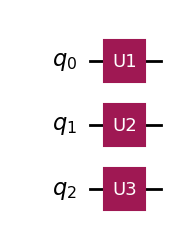

In [ ]:
qc = QuantumCircuit(3)
qc.unitary(Operator(training[0]), [0], label="U1")
qc.unitary(Operator(training[1]), [1], label="U2")
qc.unitary(Operator(training[2]), [2], label="U3")
qc.draw('mpl')

2. Bipartite entangled:  $\psi_{BE}=U_1^{rand}|0\rangle \otimes \left(U_2^{rand} \otimes U_3^{rand}\right) |\psi_+\rangle$

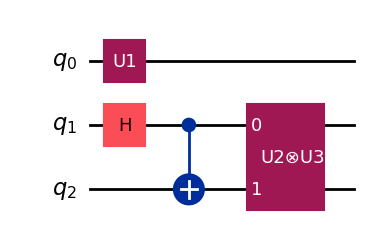

In [8]:
qc = QuantumCircuit(3)
qc.unitary(Operator(training[0]), [0], label="U1")
qc.h(1)
qc.cx(1,2)
U_ = np.kron(training[1],training[2])
qc.unitary(Operator(U_), [1,2], label="U2⊗U3")
qc.draw('mpl')

3. GHZ states:  $|\Psi_{\text{GHZ}}\rangle = \sqrt{K_{\text{GHZ}}} \left( \cos(\delta)|0\rangle|0\rangle|0\rangle + \sin(\delta)e^{i\phi} |\varphi_A\rangle |\varphi_B\rangle |\varphi_C\rangle \right)$

Where we find:

\begin{aligned}
|\varphi_A\rangle &= \cos(\alpha)|0\rangle + \sin(\alpha)|1\rangle \\
|\varphi_B\rangle &= \cos(\beta)|0\rangle + \sin(\beta)|1\rangle \\
|\varphi_C\rangle &= \cos(\gamma)|0\rangle + \sin(\gamma)|1\rangle\\
K_{\text{GHZ}} &= \frac{1}{1 + \cos(\delta) \sin(\delta) \cos(\alpha) \cos(\beta) \cos(\varphi)}
\end{aligned}
Where this parameters are bounded as: $(\alpha , \beta ,\gamma)\in (0,\pi/2]$, $\delta\in (0,\pi/4]$ and $\phi\in [0,2\pi)$

For this, I considered 4 qubits as to encode the cos(delta) sin(delta) I'll need to us a conditional rotation. Also, to encode the $\phi$ states the Ry gate we'll be needed as, acting on $|0\rangle$ it produces the desired states because:
$$RY(\theta) =
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\
\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{pmatrix}$$

We need to say that it is important to only apply a second layer of RY if and only if the state is in |1>. For this purpose we need to use the conditional ry rotations.

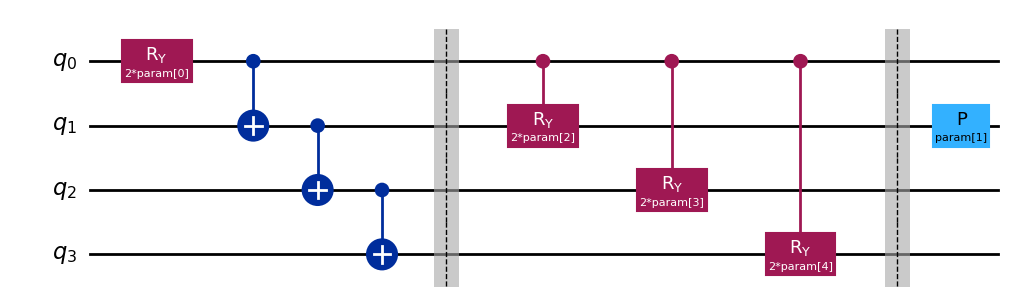

In [9]:
qc = QuantumCircuit(4)
delta,phi,alpha,beta,gamma = ParameterVector('param',5)
qc.ry(2 * delta,0)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.barrier()
qc.cry(2 * alpha,0,1)
qc.cry(2 * beta,0,2)
qc.cry(2 * gamma,0,3)
qc.barrier()
qc.p(phi,1)
qc.draw('mpl')


3. W-states
For these states, we will use the following parameterized state:
$$|\psi_W \rangle  = K_W \left( a|001\rangle + b|010\rangle + c|100\rangle + d |000\rangle \right)$$
Where the parameters (a,b,c,d) are random parameters generated from a plain distribution in the interval (0,1).

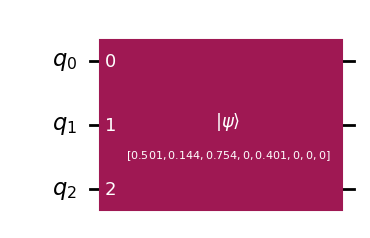

In [10]:

a, b, c, d = np.random.rand(4)

# Normalize
norm = np.sqrt(a**2 + b**2 + c**2 + d**2)
# We normalize the probabilities so the quantum state is normalized
a, b, c, d = a/norm, b/norm, c/norm, d/norm

# Define state vector in computational basis order: |000>, |001>, ..., |111>
state_vector = [d, a, b, 0, c, 0, 0, 0]

# Initialize circuit
qc = QuantumCircuit(3)
qc.initialize(state_vector, [0, 1, 2])
qc.draw('mpl')

## Three qubit entanglement detection

In [28]:
def cost_fun(params,ansatz1,ansatz2,backend):
    ansatz2 = ansatz2.assign_parameters(params)
    isa_ansatz = transpile(ansatz1,backend=backend)
    isa_ansatz2 = transpile(ansatz2,backend=backend)
    sv1 = Statevector(isa_ansatz)
    sv2 = Statevector(isa_ansatz2)
    fid = state_fidelity(sv1,sv2)
    return -fid

In [34]:
ansatz_sep = QuantumCircuit(3)
params = ParameterVector('θ',9)
ansatz_sep.ry(params[0],0)
ansatz_sep.rx(params[1],0)
ansatz_sep.rz(params[2],0)
ansatz_sep.rx(params[3],1)
ansatz_sep.ry(params[4],1)
ansatz_sep.rz(params[5],1)
ansatz_sep.rx(params[6],2)
ansatz_sep.ry(params[7],2)
ansatz_sep.rz(params[8],2)
real_label= []
q = 0
geom_entr = []
alpha_beta_gamma_bounds = (0, np.pi / 2)
delta_bounds = (0, np.pi / 4)
phi_bounds = (0, 2 * np.pi)
for i in range(0,int(len(training)/8),3):
    print(f'State {q}')
    q+=1
    x0 = np.random.rand(9) * 2 * np.pi
    print(len(x0))
    rand_num = np.random.rand()
    # We select randomely if the generated state is entangled or not
    if rand_num <= 1/2:   
        rand_ent = np.random.rand()
        real_label.append(1)
        if rand_ent <= 1/2:
            # Entangled state generator
            qc = QuantumCircuit(3)
            qc.unitary(Operator(training[i]), [0], label="U1")
            qc.h(1)
            qc.cx(1,2)
            U_ = np.kron(training[i+1],training[i+2])
            qc.unitary(Operator(U_), [1,2], label="U2⊗U3")
        if False:
            #elif rand_ent>1/3 and rand_ent<=2/3:
            print('GHZ')
            qc = QuantumCircuit(4)
            delta,phi,alpha,beta,gamma = ParameterVector('param',5)
            qc.ry(2 * delta,0)
            qc.cx(0,1)
            qc.cx(1,2)
            qc.cx(2,3)
            qc.barrier()
            qc.cry(2 * alpha,0,1)
            qc.cry(2 * beta,0,2)
            qc.cry(2 * gamma,0,3)
            qc.barrier()
            qc.p(phi,1)
            alpha_val = np.random.uniform(*alpha_beta_gamma_bounds)
            beta_val = np.random.uniform(*alpha_beta_gamma_bounds)
            gamma_val = np.random.uniform(*alpha_beta_gamma_bounds)
            delta_val = np.random.uniform(*delta_bounds)
            phi_val = np.random.uniform(*phi_bounds)
            params = [delta_val, phi_val, alpha_val, beta_val, gamma_val]
            bound_circuit = qc.assign_parameters(params)
            final_state = Statevector.from_instruction(bound_circuit)
            # Trace out qubit 0
            reduced_state = partial_trace(final_state, [0])
            print(type(reduced_state))
            qc = reduced_state.to_circuit()
        elif rand_ent>1/2:
            a, b, c, d = np.random.rand(4)
            norm = np.sqrt(a**2 + b**2 + c**2 + d**2)
            # We normalize the probabilities so the quantum state is normalized
            a, b, c, d = a/norm, b/norm, c/norm, d/norm
            # Define state vector in computational basis order: |000>, |001>, ..., |111>
            state_vector = [d, a, b, 0, c, 0, 0, 0]
            # Initialize circuit
            qc = QuantumCircuit(3)
            qc.initialize(state_vector, [0, 1, 2])
    elif rand_num>1/2:
        # Separated state
        real_label.append(0)
        qc =QuantumCircuit(3)
        qc.unitary(Operator(np.array(training[i])), [0], label="U0")
        qc.unitary(Operator(np.array(training[i+1])), [1], label="U1")
        qc.unitary(Operator(np.array(training[i+2])), [2], label="U2")
        qc.barrier()
    res = minimize(cost_fun,x0,args = (qc,ansatz_sep,backend),method='cobyla',tol=0.1)
    geom_entr.append(-res['fun'])

State 0
9
State 1
9
State 2
9
State 3
9
State 4
9
State 5
9
State 6
9
State 7
9
State 8
9
State 9
9
State 10
9
State 11
9
State 12
9
State 13
9
State 14
9
State 15
9
State 16
9
State 17
9
State 18
9
State 19
9
State 20
9
State 21
9
State 22
9
State 23
9
State 24
9
State 25
9
State 26
9
State 27
9
State 28
9
State 29
9
State 30
9
State 31
9
State 32
9
State 33
9
State 34
9
State 35
9
State 36
9
State 37
9
State 38
9
State 39
9
State 40
9
State 41
9
State 42
9
State 43
9
State 44
9
State 45
9
State 46
9
State 47
9
State 48
9
State 49
9
State 50
9
State 51
9
State 52
9
State 53
9
State 54
9
State 55
9
State 56
9
State 57
9
State 58
9
State 59
9
State 60
9
State 61
9
State 62
9
State 63
9
State 64
9
State 65
9
State 66
9
State 67
9
State 68
9
State 69
9
State 70
9
State 71
9
State 72
9
State 73
9
State 74
9
State 75
9
State 76
9
State 77
9
State 78
9
State 79
9
State 80
9
State 81
9
State 82
9
State 83
9


In [36]:
real_label

[1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0]

In [42]:
E = [(1 - p**2) for p in geom_entr]
print(E)
for i in range(len(E)):
    # I set a bound at 0.1 for classification of separable and entangled
    if E[i] < 0.01:
        E[i]=0
    elif E[i]>=0.01:
        E[i]=1
q= 0
for z in range(len(real_label)):
    if E[z]==real_label[z]:
        q+=1
print(f'The method`s accuaracy is {(q/len(real_label))*100}%')

[np.float64(0.7515254173381845), np.float64(0.005759182188784018), np.float64(0.5683246425132313), np.float64(0.0034189125612209548), np.float64(0.7529189638336409), np.float64(0.0059641514331825185), np.float64(0.007869995794607898), np.float64(0.00955185443970441), np.float64(0.004771755064035155), np.float64(0.003635814907326007), np.float64(0.0057469257690316855), np.float64(0.006561792174453296), np.float64(0.006467617988160312), np.float64(0.7516440012305682), np.float64(0.7508867270757176), np.float64(0.003806894760149282), np.float64(0.005901727591323014), np.float64(0.0044878459361140655), np.float64(0.007488288426209078), np.float64(0.7521753743093533), np.float64(0.007971584848419644), np.float64(0.7526997852302977), np.float64(0.13663753545394786), np.float64(0.005096817093798056), np.float64(0.003938994085103897), np.float64(0.7506353697358958), np.float64(0.006300020710464649), np.float64(0.5742809825069741), np.float64(0.009686200035493697), np.float64(0.0028937333862589

# TO DOS:
1. Study the non-maximally entangled and mixed separable states.
2. Consider SVM.
3. Problem using GHZ parameterized state. GHZ using STATEVECTOR
4. Cost function plot!!
5. Separability and Entanglement theory.